### IMPORT LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import tensorflow.keras as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,f1_score,accuracy_score,roc_auc_score,roc_curve

### IMPORT DATASET

In [5]:
x= pd.read_csv("../data/X_train.csv") 
y = pd.read_csv("../data/Y_train.csv")
x_test = pd.read_csv("../data/X_test.csv")

In [6]:
y_trial = pd.read_csv("../data/Y_train.csv")
y_trial.value_counts()

Outcome
AD         303
C           97
dtype: int64

In [7]:
y.replace({'C':0,'AD':1}, inplace = True)

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, shuffle= True, random_state=42)

In [60]:
def ae_reduce(x_train, x_valid):
    n_input = len(x_train.columns)
    # n_hidden = len(x_train.columns)
    n_latent = 190
    epoch = 200
    lr = 1e-3
    encoder = Sequential([
        Dense(n_input, activation='selu', input_dim=n_input),
        # Dense(n_hidden, activation='selu'),
        Dense(n_latent, activation='selu')
    ])
    decoder = Sequential([
        # Dense(n_hidden, activation='selu'),
        Dense(n_input, activation='selu')
    ])
    stacked_ae = Sequential([encoder,decoder])
    checkpoint_cb = tf.callbacks.ModelCheckpoint("my__model.h5",save_best_only=True)
    early_stopping_cb = tf.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
    stacked_ae.compile(optimizer = tf.optimizers.Adam(learning_rate = lr), loss = tf.losses.mean_squared_error, metrics='accuracy')
    # history = stacked_ae.fit(x_train, x_train, epochs=epoch, validation_data=[X_test, X_test],callbacks=[checkpoint_cb, early_stopping_cb])
    history = stacked_ae.fit(x_train, x_train, epochs=epoch, validation_data=[x_valid, x_valid], verbose=0)
    train_encoded = encoder.predict(x_train)
    full_encoded = stacked_ae.predict(x_train)
    test_encoded = encoder.predict(x_valid)
    # print('mse:',mean_squared_error(stacked_ae.predict(full_encoded), x_train))
    train_encoded = pd.DataFrame(train_encoded)
    test_encoded = pd.DataFrame(test_encoded)
    train_encoded['train_status'] = 'train' 
    test_encoded['train_status'] = 'test'
    df_ae = pd.concat([train_encoded, test_encoded], axis = 0)
    return df_ae

In [62]:
df_ae = ae_reduce(x_train, x_valid)

Epoch 1/200
10/10 [==============================] - 4s 120ms/step - loss: 2.6556 - accuracy: 0.0033 - val_loss: 0.5566 - val_accuracy: 0.0900
Epoch 2/200
10/10 [==============================] - 0s 43ms/step - loss: 0.3810 - accuracy: 0.0967 - val_loss: 0.2711 - val_accuracy: 0.2300
Epoch 3/200
10/10 [==============================] - 0s 43ms/step - loss: 0.2265 - accuracy: 0.2500 - val_loss: 0.1770 - val_accuracy: 0.2300
Epoch 4/200
10/10 [==============================] - 0s 41ms/step - loss: 0.1657 - accuracy: 0.2067 - val_loss: 0.1562 - val_accuracy: 0.0900
Epoch 5/200
10/10 [==============================] - 0s 35ms/step - loss: 0.1488 - accuracy: 0.0800 - val_loss: 0.1385 - val_accuracy: 0.2100
Epoch 6/200
10/10 [==============================] - 1s 105ms/step - loss: 0.1379 - accuracy: 0.2067 - val_loss: 0.1354 - val_accuracy: 0.2800
Epoch 7/200
10/10 [==============================] - 1s 56ms/step - loss: 0.1331 - accuracy: 0.2800 - val_loss: 0.1303 - val_accuracy: 0.2100
Epoc

In [64]:
df_ae['train_status'].value_counts()

train    300
test     100
Name: train_status, dtype: int64

### PCA

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=57)


In [216]:
y

,Outcome
0,0
1,1
2,0
3,0
4,1
...,...
395,1
396,1
397,1
398,1


In [236]:
x_viz = pca.fit_transform(x)
x_viz = pd.DataFrame(x_viz)
y = pd.DataFrame(y)
# x_viz_1 = pd.concat([x_viz,y], axis = 1)

In [252]:
y.value_counts()

Outcome
1          303
0           97
dtype: int64

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [305]:
df_viz = pd.concat([x_viz,y], axis = 1)

In [310]:
df_viz['Outcome'] = df_viz['Outcome'].replace({0:"Control",1:"Disease"})

<AxesSubplot: xlabel='0', ylabel='1'>

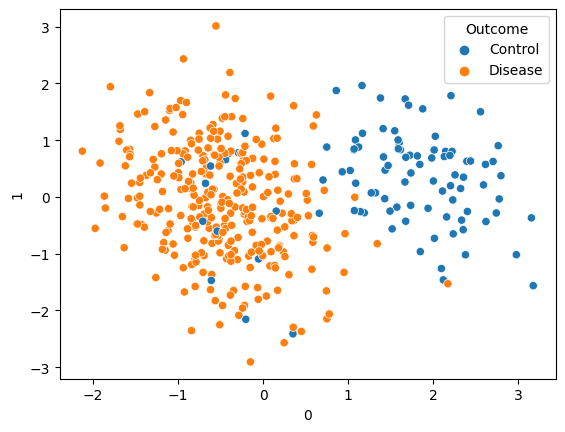

In [311]:
# !pip install seaborn
import seaborn as sns
sns.scatterplot(data=df_viz, x=0, y=1, hue="Outcome")

In [67]:
x_pca_train = pca.fit_transform(x_train)
x_pca_valid = pca.transform(x_valid)

In [68]:
print(sum(pca.explained_variance_ratio_))

0.7077119103739355


In [90]:
train_ae_x = df_ae.loc[df_ae['train_status'] =='train']
train_ae_x.drop(columns = ['train_status'], inplace = True)

C:\Users\nahomw\AppData\Local\Temp\ipykernel_27772\1910710096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ae_x.drop(columns = ['train_status'], inplace = True)


In [92]:
train_ae_x

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,0.286011,-1.681617,-1.607033,0.750308,-1.291434,1.755265,0.011078,-1.658436,-1.562615,-1.720451,...,-0.557999,-1.172544,-0.967577,0.428967,0.268811,0.264306,-1.747202,-1.462740,-1.147379,0.752695
1,0.379294,-1.636155,-1.430053,0.630301,-0.142524,1.089372,1.083219,-1.715190,-1.554196,-1.694621,...,-1.087803,-1.303281,0.116535,0.707242,0.798143,-0.133823,-1.748160,-1.463585,-1.401313,1.455236
2,0.908696,-1.671099,-1.611066,0.448563,-1.218104,1.052349,1.213578,-1.715072,-1.459007,-1.719276,...,-0.763722,-0.655116,-0.695699,0.586953,0.099654,0.991306,-1.745728,-1.481762,-1.468218,0.993800
3,-0.392862,-1.670521,-1.219733,0.046698,-0.861674,0.661535,1.135326,-1.712400,-1.599550,-1.719556,...,-0.424196,-1.246706,-0.386247,0.707216,0.873591,1.810715,-1.733457,-1.134984,-1.673585,0.206294
4,0.403591,-1.712968,-1.476937,0.282476,-0.952883,1.081380,0.250162,-1.697196,-1.433646,-1.711076,...,-0.512201,-1.409165,0.225623,0.659767,-0.270583,0.488124,-1.739537,-1.380277,-1.557396,1.012737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.881916,-1.662267,-1.500192,0.046194,-0.984068,1.051335,1.308702,-1.704325,-1.473874,-1.721303,...,-0.521498,-1.007404,-0.879530,0.250384,0.821218,1.525253,-1.736708,-1.050555,-1.057167,0.206922
296,0.674289,-1.692174,-1.542225,1.152259,-0.841977,1.320291,0.506080,-1.669426,-1.598777,-1.692820,...,-0.947423,-1.367081,-0.877269,0.022208,0.860660,1.165986,-1.742857,-1.476454,-1.378397,1.315948
297,0.546966,-1.686088,-1.386902,-0.474575,-0.745600,0.885027,1.557217,-1.653044,-1.476545,-1.727185,...,-0.689841,-1.416341,0.129194,1.018297,1.110545,1.066289,-1.745026,-1.387244,-1.461599,1.134802
298,0.583664,-1.660465,-1.564322,0.571392,-1.122003,1.088288,0.730211,-1.685058,-1.592363,-1.707006,...,-1.003026,-1.418858,-0.260910,-0.065412,1.285587,0.488780,-1.750642,-1.579210,-1.328196,1.324674


In [81]:
train_ae_x = df_ae.loc[df_ae['train_status'] =='train']
train_ae_x.drop(columns = ['train_status'], inplace = True)

[0      True
 1      True
 2      True
 3      True
 4      True
       ...  
 95    False
 96    False
 97    False
 98    False
 99    False
 Name: train_status, Length: 400, dtype: bool]

In [103]:
def pca_reduce(x_train, x_valid):
        pca = PCA(n_components=57)
        x_pca_train = pca.fit_transform(x_train)
        x_pca_valid = pca.transform(x_valid)
        x_pca_train = pd.DataFrame(x_pca_train)
        x_pca_valid = pd.DataFrame(x_pca_valid)
        x_pca_train['train_status'] = 'train' 
        x_pca_valid['train_status'] = 'test'
        df_pca = pd.concat([x_pca_train, x_pca_valid], axis = 0)
        return df_pca

In [108]:
df_pca = pca_reduce(x_train, x_valid)
df_pca


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,train_status
0,-1.471503,-0.938684,0.722844,-1.080448,-0.550212,-0.456904,-0.594158,0.299010,-0.345354,-0.259012,...,-0.545007,-0.893105,0.532089,0.522779,-0.052114,-0.028399,-0.059819,-0.057401,-0.657473,train
1,0.597896,0.749902,-0.545454,-2.120778,0.061519,-0.388359,0.616536,0.116393,-0.117526,-0.922683,...,0.327284,-0.074456,0.650318,-0.026963,0.519379,0.172174,0.193085,-0.282714,-0.995653,train
2,1.661038,0.402187,-0.044178,-0.678541,-0.215063,-0.526773,-0.060653,0.985703,-0.430016,-0.696795,...,0.690787,-0.034156,-0.475457,-0.791914,0.400384,0.595436,-0.051831,-0.457005,-0.679141,train
3,2.520373,-0.526457,0.834462,2.881337,-1.429538,1.487006,-0.232425,0.340083,0.237961,-0.114992,...,-0.094980,-0.318086,0.226651,0.078899,-0.500580,-0.383087,-0.585835,0.790962,-0.124492,train
4,-1.255171,0.281806,0.305122,0.278138,0.877982,0.599567,-1.711069,0.710685,-0.092102,-0.224902,...,-0.677101,0.341953,0.489739,0.256139,1.013076,-0.023266,0.132844,0.097535,0.356303,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.250600,0.519219,1.023173,0.915650,1.006372,0.617418,-0.088070,-0.300852,0.157686,0.642070,...,0.232269,-0.112554,0.062340,0.333561,-0.100245,0.087601,-0.401799,0.047381,0.417175,test
96,1.267989,-0.913610,0.256582,-0.345304,-1.081689,0.917660,0.181186,-0.575468,0.276676,0.031298,...,0.128917,-0.497415,-1.057189,0.884635,0.099020,0.289597,0.149911,0.058205,-0.782336,test
97,-0.038408,0.269255,0.966371,-0.778252,0.730750,-0.204290,0.505082,-1.373290,0.878629,0.333496,...,-0.185657,-0.811218,0.012346,0.095360,0.174385,-0.156357,-0.189497,-0.042771,-1.077269,test
98,-0.073523,0.212095,0.826139,0.077370,-0.960395,0.301680,-0.671235,-0.432688,0.755138,0.426795,...,0.046492,-0.222965,0.387004,0.450156,0.016386,-0.320359,0.592497,0.631707,-1.317769,test


In [110]:
from sklearn.linear_model import LogisticRegression
def logit_mod(df):
    train_encoded = df.loc[df['train_status'] =='train']
    train_encoded.drop(columns = ['train_status'], inplace = True)
    test_encoded = df.loc[df['train_status'] =='test']
    test_encoded.drop(columns = ['train_status'], inplace = True)
    model_logit = LogisticRegression(solver='liblinear', random_state=0).fit(train_encoded,y_train)
    print('classification_report:',classification_report(model_logit.predict(train_encoded),y_train))
    print('classification_report:',classification_report(model_logit.predict(test_encoded),y_valid))

In [113]:
logit_mod(df_ae)

classification_report:               precision    recall  f1-score   support

           0       0.96      1.00      0.98        68
           1       1.00      0.99      0.99       232

    accuracy                           0.99       300
   macro avg       0.98      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

classification_report:               precision    recall  f1-score   support

           0       0.85      0.92      0.88        24
           1       0.97      0.95      0.96        76

    accuracy                           0.94       100
   macro avg       0.91      0.93      0.92       100
weighted avg       0.94      0.94      0.94       100



C:\Users\nahomw\AppData\Local\Temp\ipykernel_27772\1884567426.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_encoded.drop(columns = ['train_status'], inplace = True)
C:\Users\nahomw\AppData\Local\Temp\ipykernel_27772\1884567426.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_encoded.drop(columns = ['train_status'], inplace = True)
c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

In [22]:
print('classification_report:',classification_report(xgb_unbalanced.predict(x_pca_valid),y_valid))

classification_report:               precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.97      0.98        59

    accuracy                           0.97        80
   macro avg       0.96      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



In [44]:
from sklearn.linear_model import LogisticRegression
model_logit = LogisticRegression(solver='liblinear', random_state=0).fit(x_pca_train,y_train)

c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [47]:
print('classification_report:',classification_report(y_train, model_logit.predict(x_pca_train)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.99      0.99        74
           1       1.00      1.00      1.00       246

    accuracy                           1.00       320
   macro avg       1.00      0.99      1.00       320
weighted avg       1.00      1.00      1.00       320



In [46]:
print('classification_report:',classification_report(y_valid, model_logit.predict(x_pca_valid)))

classification_report:               precision    recall  f1-score   support

           0       0.91      0.91      0.91        23
           1       0.96      0.96      0.96        57

    accuracy                           0.95        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.95      0.95      0.95        80



In [23]:
from sklearn import svm
pca_svc = svm.SVC()
pca_svc.fit(x_pca_train, y_train)
print('classification_report:',classification_report(y_valid, pca_svc.predict(x_pca_valid)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.97      1.00      0.98        57

    accuracy                           0.97        80
   macro avg       0.98      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### XGboost Classifier

#### Grid-search CV

In [199]:
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'max_depth': range (2, 7, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.05, 0.01, 0.001]
    # 'alpha':[0.01,0.1,1,10]
}


In [200]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [201]:
grid_search.fit(train_encoded,y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

In [202]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [156]:
xgb_unbalanced = XGBClassifier(n_estimators=100,max_depth=2, learning_rate=0.05, alpha=1)
xgb_unbalanced.fit(train_encoded,y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [157]:
print('classification_report:',classification_report(y_train, xgb_unbalanced.predict(train_encoded)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.85      0.92        71
           1       0.95      1.00      0.98       229

    accuracy                           0.96       300
   macro avg       0.98      0.92      0.95       300
weighted avg       0.97      0.96      0.96       300



In [158]:
print('classification_report:',classification_report(y_valid, xgb_unbalanced.predict(test_encoded)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.77      0.87        26
           1       0.93      1.00      0.96        74

    accuracy                           0.94       100
   macro avg       0.96      0.88      0.92       100
weighted avg       0.94      0.94      0.94       100



In [ ]:

xgb_unbalanced.fit(train_encoded,y_train)

In [40]:
grid_search.fit(x_valid,y_valid)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


KeyboardInterrupt: 

In [200]:
xgb_raw = XGBClassifier( n_estimators=60,max_depth=2, learning_rate=0.1)
xgb_raw.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=60, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [201]:
print('classification_report:',classification_report(y_train, xgb_raw.predict(x_train)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.99      0.99        74
           1       1.00      1.00      1.00       246

    accuracy                           1.00       320
   macro avg       1.00      0.99      1.00       320
weighted avg       1.00      1.00      1.00       320



In [202]:
print('classification_report:',classification_report(y_valid, xgb_raw.predict(x_valid)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.57      0.72        23
           1       0.85      1.00      0.92        57

    accuracy                           0.88        80
   macro avg       0.93      0.78      0.82        80
weighted avg       0.89      0.88      0.86        80



### Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier
rf_mod = RandomForestClassifier()
rf_mod.fit(x_train,y_train)


C:\Users\nahomw\AppData\Local\Temp\ipykernel_26636\3946408733.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_mod.fit(x_train,y_train)


RandomForestClassifier()

In [139]:

print('classification_report:',classification_report(y_train, rf_mod.predict(x_train)))

classification_report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00       229

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [60]:
print('classification_report:',classification_report(y_valid, rf_mod.predict(x_valid)))

ValueError: X has 360 features, but DecisionTreeClassifier is expecting 190 features as input.

In [140]:
rf_mod.fit(x_train,y_train)
print('classification_report:',classification_report(y_valid, rf_mod.predict(x_valid)))

C:\Users\nahomw\AppData\Local\Temp\ipykernel_26636\779682960.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_mod.fit(x_train,y_train)


classification_report:               precision    recall  f1-score   support

           0       1.00      0.35      0.51        26
           1       0.81      1.00      0.90        74

    accuracy                           0.83       100
   macro avg       0.91      0.67      0.71       100
weighted avg       0.86      0.83      0.80       100



In [145]:
rf_mod_red = RandomForestClassifier()
rf_mod_red.fit(train_encoded,y_train)
print('classification_report:',classification_report(y_valid, rf_mod_red.predict(test_encoded)))

C:\Users\nahomw\AppData\Local\Temp\ipykernel_26636\1162444599.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_mod_red.fit(train_encoded,y_train)


classification_report:               precision    recall  f1-score   support

           0       1.00      0.50      0.67        26
           1       0.85      1.00      0.92        74

    accuracy                           0.87       100
   macro avg       0.93      0.75      0.79       100
weighted avg       0.89      0.87      0.85       100



In [144]:
print('classification_report:',classification_report(y_test, rf_mod_red.predict(test_encoded)))

NameError: name 'y_test' is not defined

In [143]:
print('Accuracy:',mean_squared_error(stacked_ae.predict(x_train), x_train))

10/10 [==============================] - 0s 4ms/step
Accuracy: 0.03624933359362187


### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
model_logit = LogisticRegression(solver='liblinear', random_state=0).fit(train_encoded, y_train)

c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [45]:
# model.predict(test_encoded, y_valid)
print('classification_report:',classification_report(y_valid, model_logit.predict(test_encoded)))
# print('classification_report:',classification_report(y_train, model_logit.predict(train_encoded)))

classification_report:               precision    recall  f1-score   support

           0       0.91      0.87      0.89        23
           1       0.95      0.96      0.96        57

    accuracy                           0.94        80
   macro avg       0.93      0.92      0.92        80
weighted avg       0.94      0.94      0.94        80



In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
model_qda = QuadraticDiscriminantAnalysis()
model_lda = LinearDiscriminantAnalysis()
# model_qda.fit(train_encoded, y_train)
model_lda.fit(x_train, y_train)
print('classification_report:',classification_report(y_valid, model_lda.predict(x_valid)))


NameError: name 'x_train' is not defined

### SVC (linear and quadratic)

In [179]:
from sklearn import svm
model_svc = svm.SVC()
model_svc.fit(train_encoded, y_train)
print('classification_report:',classification_report(y_valid, model_svc.predict(test_encoded)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.97      1.00      0.98        57

    accuracy                           0.97        80
   macro avg       0.98      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [180]:
print('classification_report:',classification_report(y_train, model_svc.predict(train_encoded)))

classification_report:               precision    recall  f1-score   support

           0       0.98      0.73      0.84        74
           1       0.92      1.00      0.96       246

    accuracy                           0.93       320
   macro avg       0.95      0.86      0.90       320
weighted avg       0.94      0.93      0.93       320



In [47]:
model_svc.fit(train_encoded, y_train)
print('classification_report:',classification_report(y_train, model_svc.predict(train_encoded)))

classification_report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.77      1.00      0.87       246

    accuracy                           0.77       320
   macro avg       0.38      0.50      0.43       320
weighted avg       0.59      0.77      0.67       320



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\

In [159]:
test_2_encoded = encoder.predict(x_test)
test_2_encoded.shape

13/13 [==============================] - 0s 3ms/step


(400, 190)

In [160]:
test_2_encoded.shape

(400, 190)

In [ ]:
accuracy_score()

In [161]:
test_2_encoded = encoder.predict(x_test)
to_file = xgb_unbalanced.predict(test_2_encoded)
# to_file_svm = model_svc.predict(test_2_encoded)

In [162]:
df_final = pd.DataFrame(to_file)
df_final.columns = ['prediction']
df_final

,prediction
0,1
1,1
2,1
3,0
4,1
...,...
395,1
396,1
397,1
398,1


In [27]:
df_prev = pd.read_csv("test_alz_pred.csv")

In [163]:
import pandas as pd
df_final['prediction'].replace({0:'C',1:'AD'}, inplace = True)

In [164]:
df_prev.head(), df_final.head()

(  prediction
 0          C
 1         AD
 2          C
 3          C
 4         AD,
   prediction
 0         AD
 1         AD
 2         AD
 3          C
 4         AD)

In [167]:
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
accuracy_score(df_final, df_prev)


0.7

In [168]:
df_final.value_counts()

prediction
AD            333
C              67
dtype: int64

In [171]:
xgb_unbalanced = XGBClassifier(n_estimators=100,max_depth=2, learning_rate=0.05, alpha=1)
xgb_unbalanced.fit(x,y)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [187]:
train_encoded = pd.DataFrame(train_encoded)
test_encoded = pd.DataFrame(test_encoded)
train_test_encoded = train_encoded.append(test_encoded)

C:\Users\nahomw\AppData\Local\Temp\ipykernel_26636\3150718206.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_encoded = train_encoded.append(test_encoded)


In [188]:
train_test_encoded.shape

(400, 190)

In [190]:
y_train = pd.DataFrame(y_train)
y_valid = pd.DataFrame(y_valid)
train_test_y = y_train.append(y_valid)

C:\Users\nahomw\AppData\Local\Temp\ipykernel_26636\2982698167.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_y = y_train.append(y_valid)


In [191]:
train_test_encoded.shape, train_test_y.shape

((400, 190), (400, 1))

In [192]:
xgb_unbalanced = XGBClassifier(n_estimators=100,max_depth=2, learning_rate=0.05, alpha=1)
xgb_unbalanced.fit(train_test_encoded,train_test_y)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [312]:
test_2_encoded = encoder.predict(x_test)
to_file = xgb_unbalanced.predict(test_2_encoded)

13/13 [==============================] - 0s 7ms/step


In [194]:
to_file

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,

In [196]:
import pandas as pd
df_prev = pd.DataFrame(to_file)
df_prev.replace({0:'C',1:'AD'}, inplace = True)

In [197]:
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
accuracy_score(df_final, df_prev)


0.97

In [198]:
df_prev.to_csv('test_alz_pred_1.csv',index = False)

In [178]:
df_final.value_counts()

prediction
AD            313
C              87
dtype: int64

In [313]:
pd.DataFrame(to_file).value_counts()

1    325
0     75
dtype: int64